# Imports

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

#device = 0
#torch.cuda.set_device(device)

%reload_ext autoreload
%autoreload 2
%matplotlib notebook
import sys
sys.path.append('../fastai/') #fastai version 1.0
from fastai.vision import *
from fastai.vision.learner import model_meta

sys.path.append('../models-pytorch/pretrained-models.pytorch')
import pretrainedmodels
from pretrainedmodels import *

import pandas as pd
import numpy as np
import os
import torch
import torchvision
from torchvision.models import *
from torchsummary import summary
from pathlib import Path
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg


PATH = Path('/home/Deep_Learner/work/network/datasets/Hypophysenadenome/')
FONT_PATH=PATH/'1984-Happines-Regular.ttf'
ROIS_CORTICOTROP = PATH/'rois_corticotrop'
ROIS_CORTICOTROP_FILTERED = PATH/'rois_corticotrop_filtered'
ROIS_GONADOTROP = PATH/'rois_gonadotrop'
ROIS_GONADOTROP_FILTERED = PATH/'rois_gonadotrop_filtered'
TILES_CORTICOTROP = PATH/'tiles_corticotrop'
TILES_GONADOTROP = PATH/'tiles_gonadotrop'
TRAIN_NAME = 'tiles_train'
TRAIN = PATH/TRAIN_NAME
TEST_NAME = 'tiles_test'
TEST = PATH/TEST_NAME
LABELS_CORTICOTROP_NAME = 'KortikotropHA_gelabled.xlsx'
LABELS_CORTICOTROP = PATH/LABELS_CORTICOTROP_NAME
LABELS_GONADOTROP_NAME = 'GonadotropeHA_gelabled.xlsx'
LABELS_GONADOTROP = PATH/LABELS_GONADOTROP_NAME
MODEL_PATH_NAME = 'models'
MODEL_PATH = PATH/MODEL_PATH_NAME

nw = 8   #number of workers for data loader
torch.backends.cudnn.benchmark=True

#def batch_stats(self, funcs:Collection[Callable]=None)->Tensor:
#        "Grab a batch of data and call reduction function `func` per channel"
#        funcs = ifnone(funcs, [torch.mean,torch.std])
#        x = self.one_batch(ds_type=DatasetType.Train, denorm=False)[0].cpu()
#        return [func(channel_view(x), 1) for func in funcs]
#        
#vision.data.ImageDataBunch.batch_stats = batch_stats

sz = 1024
bs = 4
epochs_frozen = 1
epochs_unfrozen = 20

#fastai defaults
tta_beta = 0.4 
tta_scale = 1.35
dropout = 0.5
wd = 0.01

#non defaults
#wd = 0.1 not better for se_resnext50
#dropout = 0.9


seed = 42
np.random.seed(seed)

num2lbs = {
    0:"corticotrop", 
    3:"silent",  
    8:"LH", 
    9:"FSH"
}

lbs2num = {l:n for n,l in num2lbs.items()}

def show(np):
    return util.np_to_pil(np)

Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]

def show_multiple_images(path, rows = 3, figsize=(128, 64)):
    imgs = [open_image(p) for p in path.ls()]
    show_all(imgs=imgs, r=rows, figsize=figsize)
    
def show_multiple_images_big(path:pathlib.Path):
    for p in path.ls():
        plt.imshow(mpimg.imread(str(p)))
        plt.show()

# Extra Models

In [ ]:
#https://github.com/PPPW/deep-learning-random-explore/blob/master/CNN_archs/cnn_archs.ipynb

## utils

In [ ]:
from fastai.torch_core import flatten_model

def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')


## Models

### NASNetAMobile

In [ ]:
def identity(x): return x

def nasnetamobile(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.nasnetamobile(pretrained=pretrained, num_classes=1000)  
    model.logits = identity
    model_meta[nasnetamobile] =  { 'cut': identity, 'split': lambda m: (list(m[0][0].children())[8], m[1]) }
    return nn.Sequential(model)

#arch_summary(lambda _: nasnetamobile(False)[0])

### se_resnext50

In [ ]:
def se_resnext50_32x4d(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnext50_32x4d(pretrained=pretrained)
    _se_resnet_meta = {'cut': -2, 'split': lambda m: (m[0][3], m[1]) }
    model_meta[se_resnext50_32x4d] =  _se_resnet_meta
    return model

#arch_summary(lambda _: pretrainedmodels.se_resnext50_32x4d(pretrained=None))

# n 

In [2]:
n='test'

#n = np.load('n.npy')
#print(n)
#
#m = n+1
##m=1
#np.save('n', m)
#print(m)

# Data 

In [22]:
#!rm -r {TRAIN/'*'}
#!rm -r {TEST/'*'}
#!cp {TILES_CORTICOTROP/'*'} {TRAIN}
#!cp {TILES_GONADOTROP/'*'} {TRAIN}

In [40]:
tile_paths_all = [p for p in (TRAIN.ls()+TEST.ls()) if p.suffix == '.png']
ids = []
for p in tqdm(tile_paths_all):
    split = p.stem.split('-')
    id = f'{split[0]}-{split[1]}'
    ids.append(id)
ids = list(set(ids))
train_pct = 0.7
valid_pct = 0.2
test_pct = 0.1
ids_train, ids_val = train_test_split(ids, test_size=valid_pct, random_state=seed)
ids_train, ids_test = train_test_split(ids_train, test_size=test_pct/train_pct, random_state=seed)

In [43]:
ids_train

['203-16', '1789-17', '1937-13']

In [44]:
ids_val

['815-16', '2193-14']

In [41]:
ids_test

['510-13']

In [42]:
for id in tqdm(ids_test):
    for p in tile_paths_all:
        if id in str(p):
            !mv {p} {TEST}

mv: '/home/Deep_Learner/work/network/datasets/Hypophysenadenome/tiles_test/510-13-III-HE-ROI_5-ACTH-tile-r3-c1-x0-y2048-w1024-h1024.png' and '/home/Deep_Learner/work/network/datasets/Hypophysenadenome/tiles_test/510-13-III-HE-ROI_5-ACTH-tile-r3-c1-x0-y2048-w1024-h1024.png' are the same file
mv: '/home/Deep_Learner/work/network/datasets/Hypophysenadenome/tiles_test/510-13-III-HE-ROI_5-ACTH-tile-r2-c2-x1024-y1024-w1024-h1024.png' and '/home/Deep_Learner/work/network/datasets/Hypophysenadenome/tiles_test/510-13-III-HE-ROI_5-ACTH-tile-r2-c2-x1024-y1024-w1024-h1024.png' are the same file
mv: '/home/Deep_Learner/work/network/datasets/Hypophysenadenome/tiles_test/510-13-III-HE-ROI_5-ACTH-tile-r1-c2-x1024-y0-w1024-h1024.png' and '/home/Deep_Learner/work/network/datasets/Hypophysenadenome/tiles_test/510-13-III-HE-ROI_5-ACTH-tile-r1-c2-x1024-y0-w1024-h1024.png' are the same file
mv: '/home/Deep_Learner/work/network/datasets/Hypophysenadenome/tiles_test/510-13-III-HE-ROI_5-ACTH-tile-r11-c2-x1024-

In [42]:
tfms = ([RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True),
        RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.475, 0.525)}, p=0.75, resolved={}, do_run=True, is_random=True),
        RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.95, 1.0526315789473684)}, p=0.75, resolved={}, do_run=True, is_random=True)],
        [])

def get_ex(): return open_image(str(TRAIN.ls()[0]))

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

#plots_f(2, 4, 12, 6, size=224)

In [52]:
df_c = pd.read_excel(LABELS_CORTICOTROP)
def label_func(path):
    s = str(path.name)    
    s = s.split('-')
    id = f'{s[0]}-{s[1]}'   
    if('LH+FSH' in s):
        return [lbs2num['gonadotrop'],lbs2num['LH'],lbs2num['FSH']]
    elif 'LH' in s:       
        return [lbs2num['gonadotrop'],lbs2num['LH']]
    elif 'FSH' in s:        
        return [lbs2num['gonadotrop'],lbs2num['FSH']]
    else:
        result = [lbs2num['corticotrop']]
        l = df_c.loc[df_c.id == id].label
        if str(lbs2num['silent']) in str(l.values[0]):
            result.append(3)        
        return result
    
def split_func(path):
    split = path.stem.split('-')
    id = f'{split[0]}-{split[1]}'
    return id in ids_val
        
data = ImageList.from_folder(path=TRAIN, extensions=['.png'])

data.split_by_valid_func(split_func)

data = data.label_from_func(label_func)
data = data.transform(tfms=tfms, size=sz) 
data = data.databunch(bs=bs, num_workers=nw, path=PATH)
data = data.normalize()

# Metrics 

# Learner

## Create

In [ ]:
arch = resnet50
learner = cnn_learner(data=data, 
                     base_arch=arch, 
                     metrics=[accuracy_thresh], 
                     ps=dropout, 
                     pretrained=True, 
                     wd = wd)

## Name

In [5]:
n='test'
nameBase = f'{n}-{arch.__name__}-size{sz}-bs{bs}'
nameBase

'test-resnet50-size1024-bs4'

## Train

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


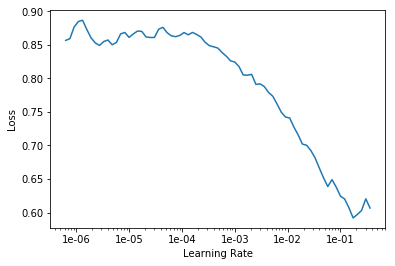

In [6]:
learner.lr_find()
learner.recorder.plot()

In [ ]:
lr = 1e-1

In [ ]:
learner.fit_one_cycle(cyc_len=epochs_frozen, max_lr=lr)

In [ ]:
nameHead = f'{nameBase}-head'

In [ ]:
learner.save(nameHead)

In [ ]:
#learner.load(nameHead)

In [ ]:
learner.unfreeze()

In [ ]:
learner.lr_find()
learner.recorder.plot()

In [ ]:
lr2 = 1e-5
lr3 = 1e-4

In [ ]:
learner.fit_one_cycle(cyc_len=epochs_unfrozen, max_lr=slice(lr2, lr3))

In [ ]:
learner.recorder.plot_losses()

In [ ]:
nameComplete = f'{nameBase}-complete'
learner.save(nameComplete)

### best learning schedules

# Interpreter

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(16)

# Validation Set

## Prediction

In [ ]:
preds,y=learner.TTA(ds_type=DatasetType.Valid, scale=1)

## AUC Score

In [ ]:
pred_score_tta_1=auc_score_1(preds,y)
pred_score_tta_1

In [ ]:
pred_score_tta_2=auc_score_2(preds,y)
pred_score_tta_2

## ROC curve and AUC on validation set

In [ ]:
fpr, tpr, thresholds, roc_auc = roc_curve_custom(preds, y)

In [ ]:
roc_auc

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

## Finding threshold on validation set

In [ ]:
import scipy.optimize as opt
from sklearn.model_selection import train_test_split

In [ ]:
pred = preds[:, 1]

In [ ]:
pred_tensor = pred
y_tensor = y

pred = np.asarray(pred)
y = np.asarray(y)

In [ ]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def F1_soft(preds,targs,th=0.,d=25.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = np.zeros(1)
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*p), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [ ]:
import sklearn
th = fit_val(pred, y)
print('Thresholds: ',th)
print('F1 macro: ', sklearn.metrics.f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.0): ', sklearn.metrics.f1_score(y, pred>0.0, average='macro'))
print('F1 micro: ', sklearn.metrics.f1_score(y, pred>th, average='micro'))

In [ ]:
from sklearn.model_selection import train_test_split
th, score, cv = 0,0,10
for i in range(cv):
    xt,xv,yt,yv = train_test_split(pred,y,test_size=0.5,random_state=i)
    th_i = fit_val(xt,yt)
    th += th_i
    score +=  sklearn.metrics.f1_score(yv, xv>th_i, average='macro')
th/=cv
score/=cv
print('Thresholds: ',th)
print('F1 macro avr:',score)
print('F1 macro: ', sklearn.metrics.f1_score(y, pred>th, average='macro'))
print('F1 micro: ', sklearn.metrics.f1_score(y, pred>th, average='micro'))


print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > 0.5).mean(axis=0))

In [ ]:
f1 =  sklearn.metrics.f1_score(y, pred>th, average=None)
bins = np.linspace(pred[:].min(), pred[:].max(), 50)
plt.hist(pred[y[:] == 0][:], bins, alpha=0.5, log=True, label='false')
plt.hist(pred[y[:] == 1][:], bins, alpha=0.5, log=True, label='true')
plt.legend(loc='upper right')
plt.axvline(x=th[0], color='k', linestyle='--')
plt.show()

# Test Set

## Single Model

In [ ]:
#learner.load('')

In [ ]:
nameBase

In [ ]:
preds_test_tta,y_test_tta=learner.TTA(ds_type=DatasetType.Test, scale=tta_scale, beta=tta_beta)
preds_test = preds_test_tta

#preds_test, _ = learner.get_preds(ds_type=DatasetType.Test)

In [ ]:
name = f'{nameBase}'

## Ensembling

In [ ]:
arch_list = []

In [ ]:
dict_arch_savedModel = {}

In [ ]:
str([a.__name__ for a in arch_list])

In [ ]:
name = f'{n}-{str([a.__name__ for a in arch_list])}_sz{sz}_ensembled'; name

In [ ]:
predsList = []
for arch in arch_list:
    learner = cnn_learner(data=data, base_arch=arch)
    learner.load(dict_arch_savedModel[arch])
    preds_test_tta,y_test_tta=learner.TTA(ds_type=DatasetType.Test, scale=1)
    predsList.append(preds_test_tta)

In [ ]:
preds_ensembled = predsList[0]
for n, _ in enumerate(predsList):
    if n == 0:
        continue
    else:
        preds_ensembled = preds_ensembled + predsList[n]
preds_ensembled = preds_ensembled/len(predsList)

In [ ]:
preds_test = preds_ensembled